In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aleksandrdubrovin/the-radarscenes-data-set")

print("Path to dataset files:", path)


C:\Users\janko\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\janko\.cache\kagglehub\datasets\aleksandrdubrovin\the-radarscenes-data-set\versions\1


Keys in HDF5 file: ['odometry', 'radar_data']
Radar fields: ('timestamp', 'sensor_id', 'range_sc', 'azimuth_sc', 'rcs', 'vr', 'vr_compensated', 'x_cc', 'y_cc', 'x_seq', 'y_seq', 'uuid', 'track_id', 'label_id')


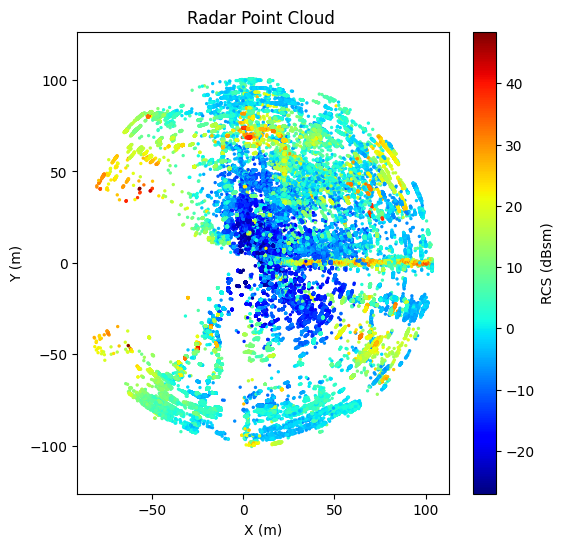

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

radar_file = r"C:\Users\janko\.cache\kagglehub\datasets\aleksandrdubrovin\the-radarscenes-data-set\versions\1\data\data\sequence_6\radar_data.h5"

with h5py.File(radar_file, 'r') as f:
   
    print("Keys in HDF5 file:", list(f.keys()))
    
    
    radar_group = f['radar_data']
    
    
    print("Radar fields:", radar_group.dtype.names)
    
    
    x_m = np.array(radar_group['x_cc'])
    y_m = np.array(radar_group['y_cc'])
    rcs = np.array(radar_group['rcs'])
    plt.figure(figsize=(6,6))
    
plt.scatter(x_m, y_m, c=rcs, cmap='jet', s=2)
plt.colorbar(label='RCS (dBsm)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Radar Point Cloud ')
plt.axis('equal')
plt.show()

In [3]:
import h5py

with h5py.File(radar_file, 'r') as f:
    radar_group = f['radar_data']
    print("Radar fields:", radar_group.dtype.names)


Radar fields: ('timestamp', 'sensor_id', 'range_sc', 'azimuth_sc', 'rcs', 'vr', 'vr_compensated', 'x_cc', 'y_cc', 'x_seq', 'y_seq', 'uuid', 'track_id', 'label_id')


Number of frames: 3735


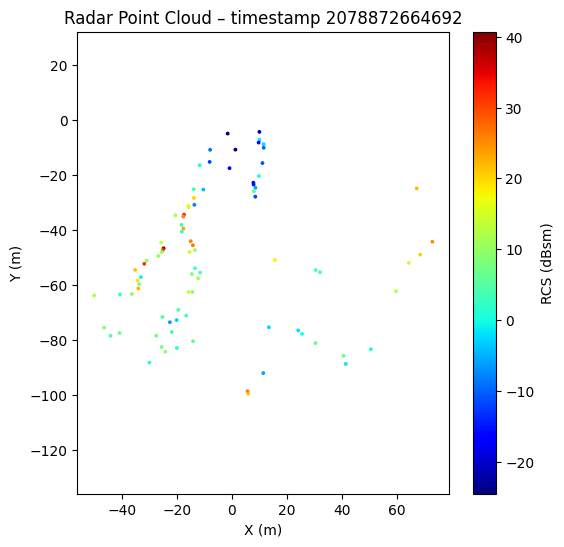

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

with h5py.File(radar_file, 'r') as f:
    radar_group = f['radar_data']
    timestamps = np.array(radar_group['timestamp'])
    x = np.array(radar_group['x_cc'])
    y = np.array(radar_group['y_cc'])
    rcs = np.array(radar_group['rcs'])

# Nézzük meg, hány különböző timestamp van:
unique_ts = np.unique(timestamps)
print("Number of frames:", len(unique_ts))

# Válasszunk ki egyet (pl. az első):
frame_ts = unique_ts[0]

# Szűrjük ki az adott időpillanat pontjait:
mask = timestamps == frame_ts
x_frame = x[mask]
y_frame = y[mask]
rcs_frame = rcs[mask]

# Rajzoljuk ki csak ezt a frame-et:
plt.figure(figsize=(6,6))
plt.scatter(x_frame, y_frame, c=rcs_frame, cmap='jet', s=3)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f'Radar Point Cloud – timestamp {frame_ts}')
plt.axis('equal')
plt.colorbar(label='RCS (dBsm)')
plt.show()


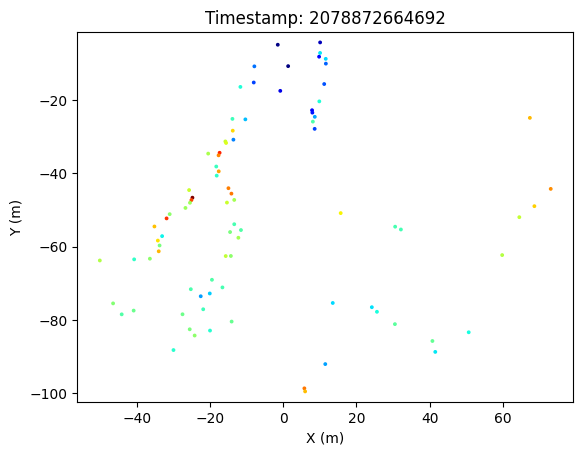

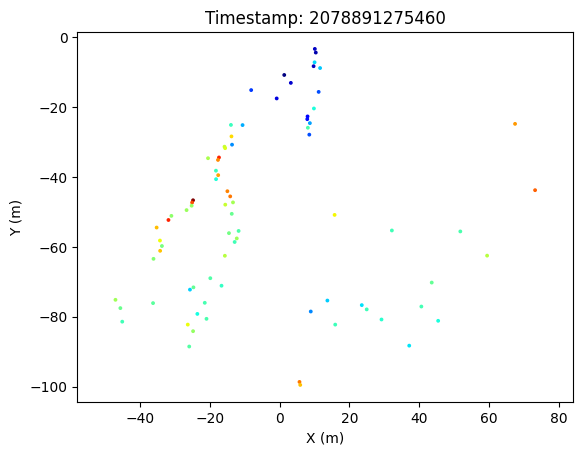

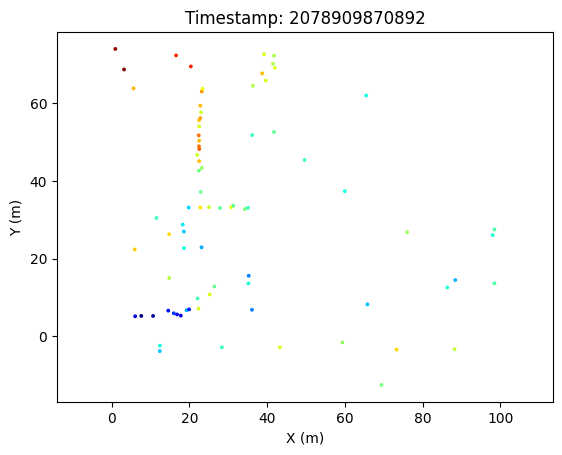

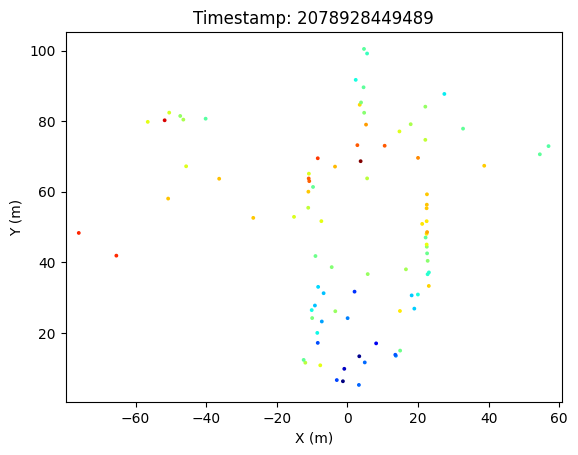

In [5]:
import time

for frame_ts in unique_ts[::1000]:  # minden 1000ik frame
    mask = timestamps == frame_ts
    plt.clf()
    plt.scatter(x[mask], y[mask], c=rcs[mask], cmap='jet', s=3)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f'Timestamp: {frame_ts}')
    plt.axis('equal')
    plt.pause(0.1)


In [7]:
#elso neural halo probalkozas, 12 fajta objektumra klasszifikacio

In [8]:


# pip install numpy h5py matplotlib scikit-learn torch torchvision
import os, random, math
import numpy as np
import h5py
from collections import Counter
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [9]:
radar_file = r"C:\Users\janko\.cache\kagglehub\datasets\aleksandrdubrovin\the-radarscenes-data-set\versions\1\data\data\sequence_6\radar_data.h5"

with h5py.File(radar_file, 'r') as f:
    d = f['radar_data']
    print("Fields:", d.dtype.names)
    # töltsünk be csak a szükséges mezőket
    x_cc = np.array(d['x_cc'])
    y_cc = np.array(d['y_cc'])
    range_sc = np.array(d['range_sc'])
    az = np.array(d['azimuth_sc'])
    rcs = np.array(d['rcs'])
    vr = np.array(d['vr_compensated'])  # javasolt a kompenzált vr
    label = np.array(d['label_id'])


Fields: ('timestamp', 'sensor_id', 'range_sc', 'azimuth_sc', 'rcs', 'vr', 'vr_compensated', 'x_cc', 'y_cc', 'x_seq', 'y_seq', 'uuid', 'track_id', 'label_id')


In [10]:
# nézzük meg a label eloszlást
print("Label counts:", Counter(label))

# Feltételezzük, hogy a nem-címkézett elemeket -1 jelöli. Ha nincs ilyen, ezt kihagyhatod.
mask_valid = label >= 0
x_cc = x_cc[mask_valid]
y_cc = y_cc[mask_valid]
range_sc = range_sc[mask_valid]
az = az[mask_valid]
rcs = rcs[mask_valid]
vr = vr[mask_valid]
label = label[mask_valid]

print("After filtering, total samples:", len(label))
print("Label counts (filtered):", Counter(label))


Label counts: Counter({np.uint8(11): 333654, np.uint8(2): 5645, np.uint8(7): 3131, np.uint8(10): 595})
After filtering, total samples: 343025
Label counts (filtered): Counter({np.uint8(11): 333654, np.uint8(2): 5645, np.uint8(7): 3131, np.uint8(10): 595})


In [11]:
# Példa input mátrix (N, D)
X = np.vstack([x_cc, y_cc, range_sc, vr, rcs, az]).T  # shape (N,6)
y = label.astype(np.int64)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (343025, 6) y shape: (343025,)


In [12]:
# egyszerű NaN/inf eltávolítás
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

# opcionálisan levágjuk a túl távoli pontokat (pl. range < 200m)
mask_range = X[:,2] < 200.0
X = X[mask_range]
y = y[mask_range]

print("After cleaning:", X.shape)


After cleaning: (343025, 6)


In [13]:
# 80% train, 20% test - stratify a label szerint, hogy megmaradjon az eloszlás
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train samples:", len(y_train), "Test samples:", len(y_test))


Train samples: 274420 Test samples: 68605


In [14]:
# Standard scaling (mean=0, std=1) a train set alapján
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-8

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std


In [15]:
class RadarPointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = RadarPointDataset(X_train_norm, y_train)
test_ds = RadarPointDataset(X_test_norm, y_test)


In [16]:
# számoljuk a train set osztályait
train_counts = Counter(y_train)
class_counts = np.array([train_counts[i] if i in train_counts else 0 for i in range(12)])
print("Train class counts:", class_counts)

# súlyosztályok inverze a samplerhez
class_weights = 1.0 / (class_counts + 1e-8)
samples_weight = np.array([class_weights[label] for label in y_train])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_ds, batch_size=512, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)


Train class counts: [     0      0   4516      0      0      0      0   2505      0      0
    476 266923]


In [17]:
class RadarClassifier12(nn.Module):
    def __init__(self, input_dim=6, num_classes=12):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RadarClassifier12(input_dim=X_train_norm.shape[1], num_classes=12).to(device)


In [18]:
# PyTorch várja a weight vektort: torch.Tensor(num_classes)
# súlyok = osztályok inverze (kisebb class_counts -> nagyobb súly)
weights_tensor = torch.from_numpy( (1.0 / (class_counts + 1e-8)) ).float().to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20


In [19]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}  loss={epoch_loss:.4f}  acc={epoch_acc:.4f}")

    # opcionális: pillanatnyi validáció minden epoch végén
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    # gyors mérőszám
    val_acc = (all_preds == all_labels).mean()
    print(f"  Val acc: {val_acc:.4f}")


Epoch 1/20  loss=0.1438  acc=0.7936
  Val acc: 0.5797
Epoch 2/20  loss=0.0474  acc=0.8853
  Val acc: 0.6959
Epoch 3/20  loss=0.0419  acc=0.9120
  Val acc: 0.7519
Epoch 4/20  loss=0.0401  acc=0.9259
  Val acc: 0.7766
Epoch 5/20  loss=0.0381  acc=0.9361
  Val acc: 0.8462
Epoch 6/20  loss=0.0362  acc=0.9433
  Val acc: 0.8417
Epoch 7/20  loss=0.0343  acc=0.9478
  Val acc: 0.8652
Epoch 8/20  loss=0.0313  acc=0.9539
  Val acc: 0.8499
Epoch 9/20  loss=0.0290  acc=0.9549
  Val acc: 0.8634
Epoch 10/20  loss=0.0282  acc=0.9603
  Val acc: 0.8952
Epoch 11/20  loss=0.0272  acc=0.9628
  Val acc: 0.9017
Epoch 12/20  loss=0.0256  acc=0.9635
  Val acc: 0.9257
Epoch 13/20  loss=0.0261  acc=0.9656
  Val acc: 0.9332
Epoch 14/20  loss=0.0276  acc=0.9657
  Val acc: 0.9323
Epoch 15/20  loss=0.0275  acc=0.9665
  Val acc: 0.9298
Epoch 16/20  loss=0.0265  acc=0.9669
  Val acc: 0.9264
Epoch 17/20  loss=0.0249  acc=0.9683
  Val acc: 0.9368
Epoch 18/20  loss=0.0239  acc=0.9679
  Val acc: 0.9246
Epoch 19/20  loss=0

Classification report:
              precision    recall  f1-score   support

           2      0.369     1.000     0.540      1129
           7      0.142     0.962     0.247       626
          10      0.191     1.000     0.321       119
          11      1.000     0.909     0.953     66731

    accuracy                          0.911     68605
   macro avg      0.426     0.968     0.515     68605
weighted avg      0.980     0.911     0.938     68605



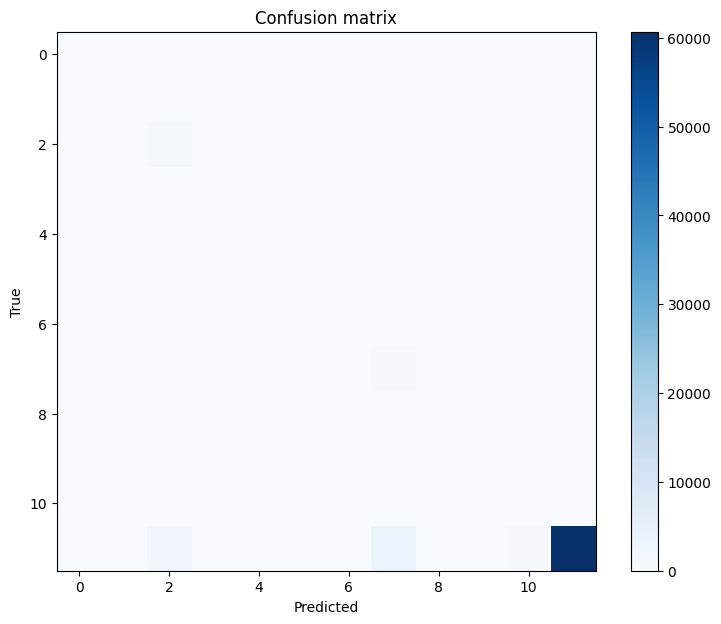

In [20]:
# utolsó validáció eredményeit már összeállítottuk all_preds, all_labels
print("Classification report:")
print(classification_report(all_labels, all_preds, digits=3))

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(12))
plt.figure(figsize=(9,7))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [9]:
#3 osztalyra szukitett klasszifikacio:

In [21]:
# új kategóriák
vehicle_ids = [0,1,2,3,4]      # minden jármű
pedestrian_ids = [7,8]         # gyalogos / csoport
static_ids = [11]              # statikus környezet

mask = np.isin(label, vehicle_ids + pedestrian_ids + static_ids)
X_raw = np.vstack([x_cc, y_cc, range_sc, az, rcs, vr]).T[mask]
y_raw = label[mask]

# új címkék hozzárendelése
y_new = np.zeros_like(y_raw)
y_new[np.isin(y_raw, vehicle_ids)] = 0
y_new[np.isin(y_raw, pedestrian_ids)] = 1
y_new[np.isin(y_raw, static_ids)] = 2

print("Új osztályok (0=vehicle, 1=pedestrian, 2=static):", Counter(y_new))


Új osztályok (0=vehicle, 1=pedestrian, 2=static): Counter({np.uint8(2): 333654, np.uint8(0): 5645, np.uint8(1): 3131})


In [22]:
np.random.seed(42)

# limitáljuk a statikus minták számát 5000-re, hogy ne domináljon
static_mask = (y_new == 2)
static_idx = np.where(static_mask)[0]
keep_static = np.random.choice(static_idx, size=5000, replace=False)

# a többit (vehicle + pedestrian) teljesen megtartjuk
non_static_idx = np.where(y_new != 2)[0]
keep_idx = np.concatenate([keep_static, non_static_idx])

X = X_raw[keep_idx]
y = y_new[keep_idx]

print("Kiegyensúlyozott osztályeloszlás:", Counter(y))


Kiegyensúlyozott osztályeloszlás: Counter({np.uint8(0): 5645, np.uint8(2): 5000, np.uint8(1): 3131})


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-8
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class Radar3ClassDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = Radar3ClassDataset(X_train_norm, y_train)
test_ds = Radar3ClassDataset(X_test_norm, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=512)


In [25]:
import torch.nn as nn

class Radar3Classifier(nn.Module):
    def __init__(self, input_dim=6, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Radar3Classifier().to(device)


In [26]:
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}/{epochs}, loss={total_loss/total:.4f}, acc={acc:.4f}")


Epoch 1/20, loss=0.5782, acc=0.7992
Epoch 2/20, loss=0.2698, acc=0.9218
Epoch 3/20, loss=0.2034, acc=0.9418
Epoch 4/20, loss=0.1643, acc=0.9515
Epoch 5/20, loss=0.1448, acc=0.9592
Epoch 6/20, loss=0.1242, acc=0.9652
Epoch 7/20, loss=0.1174, acc=0.9651
Epoch 8/20, loss=0.1076, acc=0.9689
Epoch 9/20, loss=0.0990, acc=0.9704
Epoch 10/20, loss=0.0897, acc=0.9739
Epoch 11/20, loss=0.0921, acc=0.9739
Epoch 12/20, loss=0.0862, acc=0.9744
Epoch 13/20, loss=0.0748, acc=0.9787
Epoch 14/20, loss=0.0732, acc=0.9779
Epoch 15/20, loss=0.0742, acc=0.9781
Epoch 16/20, loss=0.0643, acc=0.9810
Epoch 17/20, loss=0.0701, acc=0.9794
Epoch 18/20, loss=0.0623, acc=0.9819
Epoch 19/20, loss=0.0597, acc=0.9840
Epoch 20/20, loss=0.0598, acc=0.9845



Classification report:
              precision    recall  f1-score   support

           0      0.989     0.998     0.994      1129
           1      0.987     0.990     0.989       627
           2      0.992     0.980     0.986      1000

    accuracy                          0.990      2756
   macro avg      0.990     0.990     0.990      2756
weighted avg      0.990     0.990     0.990      2756



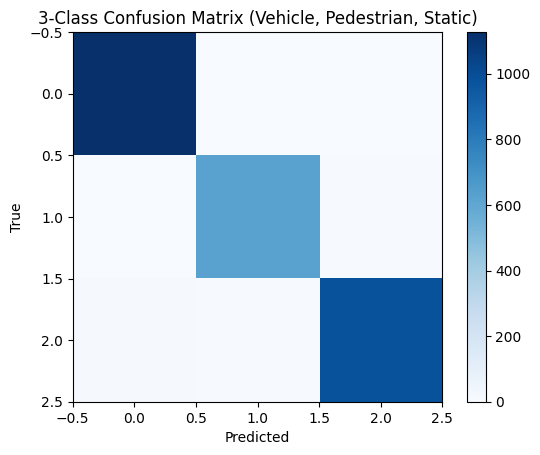

In [27]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model(Xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

print("\nClassification report:")
print(classification_report(all_labels, all_preds, digits=3))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("3-Class Confusion Matrix (Vehicle, Pedestrian, Static)")
plt.show()
